In [113]:
import nengo
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

In [1048]:
    # Sample a different tau for each neuron
    N = 100
    taus = np.logspace(-1, 1, N)

    # Sample the impulse response
    T = 50.0
    dt = 1e-3
    ts = np.arange(0, T, dt)
    N_smpls = len(ts)
    F = np.exp(-ts[:, None] / taus[None, :])

    # Sample characteristic delays
    N_delays = 73
    thetas = 5.0 * np.power(np.linspace(0.1, 1, N_delays), 3.0)
    #G = np.exp(-np.square(thetas[None, :] - ts[:, None]) / 0.01)
    G = (ts[:, None] ** thetas[None, :]) * np.exp(-ts[:, None])
    G /= np.sum(G, axis=0)[None, :]

    # Compute the linear operator that decodes these delays
    D = np.linalg.lstsq(F, G, rcond=1e-6)[0]
    D /= np.max(F @ D, axis=0)[None, :]

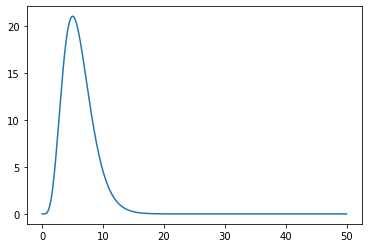

In [1049]:
fig, ax = plt.subplots()
ax.plot(ts, (ts ** 5) * np.exp(-ts / 1.0))

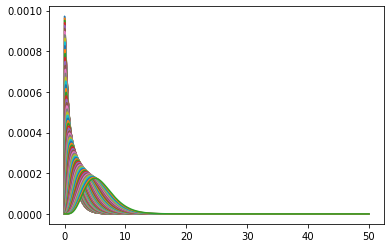

In [1050]:
fig, ax = plt.subplots()
ax.plot(ts, G);

(0.0, 5.0)

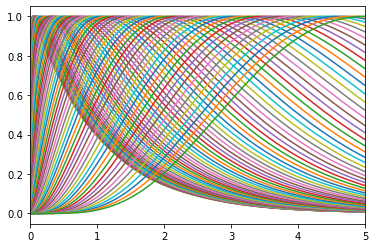

In [1051]:
fig, ax = plt.subplots()
ax.plot(ts, F @ D);
ax.set_xlim(0, 5)

In [1074]:
with nengo.Network() as model:
    us = nengo.Node(lambda t: np.exp(-t / taus))
    xs = nengo.Ensemble(
        n_neurons=N_delays,
        dimensions=N_delays,
        encoders=np.eye(N_delays),
        intercepts=nengo.dists.Uniform(0.4, 0.6),
        max_rates=nengo.dists.Uniform(20, 50),
        noise=nengo.processes.FilteredNoise(synapse=0.1, dist=nengo.dists.Gaussian(mean=0.0, std=0.1)))

    nengo.Connection(us, xs, transform=D.T)

    p_us = nengo.Probe(us, synapse=None)
    p_xs = nengo.Probe(xs.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(5.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

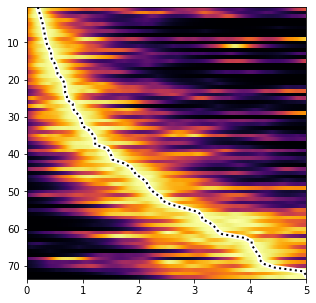

In [1075]:
fig, ax = plt.subplots(figsize=(5.0, 5.0))
ts = sim.trange()
As = sim.data[p_xs]
As = nengo.Lowpass(tau=0.3).filtfilt(As, dt=1e-3)
As_max = np.max(As, axis=0)
As_max_idcs = np.argmax(As, axis=0)
idcs = np.argsort(As_max_idcs)
As_max_ts = ts[As_max_idcs[idcs]]

ax.imshow((As[:, idcs] / As_max[idcs]).T, extent=(0, 5.0, N_delays + 0.5, 0.5), cmap='inferno', interpolation='nearest');
ax.plot(As_max_ts, np.arange(0.5, N_delays + 0.5), linewidth=5, color='white', alpha=1)
ax.plot(As_max_ts, np.arange(0.5, N_delays + 0.5), linestyle=':', linewidth=2, color='k', alpha=1)
ax.set_aspect('auto')

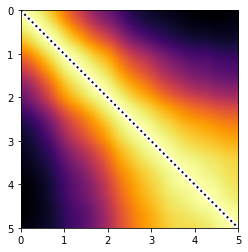

In [1077]:
fig, ax = plt.subplots()
As_len = np.linalg.norm(As, axis=1)
As_norm = As / As_len[:, None]
ax.imshow(As_norm @ As_norm.T, cmap='inferno', origin='upper', extent=(0, 5, 5, 0))
ax.plot(ts, ts, linewidth=5, color='white', alpha=1)
ax.plot(ts, ts, linestyle=':', linewidth=2, color='k', alpha=1)


In [1017]:
np.max(As_norm @ As_norm.T)

1.0000000000000009